In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [12]:
max_degree = 20
n_train, n_test = 100,100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5,1.2,-3.4,5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1,-1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
# labels的维度
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [13]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.0115],
         [-1.3105]]),
 tensor([[ 1.0000e+00, -1.1507e-02,  6.6206e-05, -2.5394e-07,  7.3053e-10,
          -1.6812e-12,  3.2243e-15, -5.3004e-18,  7.6239e-21, -9.7476e-24,
           1.1217e-26, -1.1734e-29,  1.1251e-32, -9.9593e-36,  8.1858e-39,
          -6.2792e-42,  4.2039e-45, -0.0000e+00,  0.0000e+00, -0.0000e+00],
         [ 1.0000e+00, -1.3105e+00,  8.5877e-01, -3.7515e-01,  1.2291e-01,
          -3.2217e-02,  7.0370e-03, -1.3175e-03,  2.1583e-04, -3.1428e-05,
           4.1188e-06, -4.9071e-07,  5.3592e-08, -5.4027e-09,  5.0575e-10,
          -4.4187e-11,  3.6194e-12, -2.7902e-13,  2.0315e-14, -1.4013e-15]]),
 tensor([ 4.9976, -1.6214]))

In [14]:
# 对模型进行训练和测试
def evaluate_loss(net, data_iter, loss):
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [15]:
# 定义训练函数
def train(train_features, test_features, train_labels, test_labels,
          num_epochs = 400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置bias
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10,train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 4.991965   1.1949599 -3.3826005  5.606491 ]]


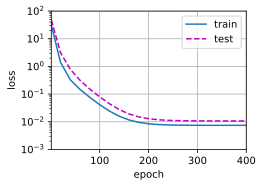

In [16]:
# 利用前四个维度
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.165497 4.774579]]


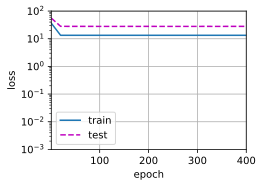

In [17]:
# 欠拟合
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 5.001234    1.2617984  -3.436479    5.21561     0.115424    1.2446308
   0.3431623  -0.0371573  -0.17781037 -0.06367818  0.11898463 -0.16307676
  -0.18956752  0.22286806 -0.11890608 -0.18132612 -0.1851573  -0.0058164
  -0.05003381  0.05774423]]


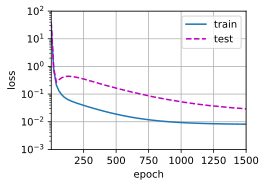

: 

: 

In [18]:
# 过拟合
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)